> La carte d'occupation du sol de Wallonie de 2019 et la carte des changements ont été réalisées dans le cadre du marché de mise à jour de WalOUS 2018 entre le SPW et Aerospacelab. Ce notebook a été réalisé afin de former les utilisateurs à l'utilisation des données dérivées de ce marché.

# Atelier Utilisateurs #2

Cette première section de l'atelier a pour objectif de vous familiariser avec les cartes d'occupation du sol issues de __WalOUS__ et les outils/librairies que `Python` offre pour manipuler ces cartes.


Dans cette section, vous apprendrez à:
- Accéder et charger les cartes d'occupation du sol
- Visualiser les cartes d'occupation du sol dérivées de WalOUS
- Rogner les cartes d'occupation du sol suivant une zone d'intérêt
- Vectoriser les cartes d'occupation du sol

Les produits __WalOUS__ considérés:
- Carte d'occupation du sol de Wallonie de 2018 (via _WMS_)
- Carte d'occupation du sol de Wallonie de 2019 (format _raster_)
- Carte d'occupation du sol de Wallonie de 2019 (format _vectoriel_)

Les principales librairies `Python` utilisées:
- rasterio
- numpy
- geopandas

_Certaines variables de ce notebook peuvent être adaptées pour rendre ce dernier plus proche de vos attentes. Ces variables seront nommées avec des majuscules._

In [2]:
from io import BytesIO
from typing import Dict, List, Union, Tuple

import backoff
from geojson import Feature
import geopandas as gpd
import numpy as np
from PIL import Image
import rasterio as rio
from rasterio.features import geometry_window, shapes
from rasterio.mask import mask
from rasterio import windows
import requests
from shapely.geometry import Point, Polygon, box

------------------

### Utilisation du service WMS

> _Objectifs_: Télécharger et visualiser la carte d'occupation du sol et les orthophotos pour une zone d'intérêt grâce au service WMS sur base d'une coordonnée

Le __Geoportail__ permet d'envoyer des requêtes `WMS` afin de télécharger et visualiser des extraits de certaines données telles que:
- la carte d'occupation du sol de Wallonie
- les orthophotos (RGB)
- les orthophotos infrarouge (IRGB)

Dans cette section, nous allons voir comment vous pouvez créer des requêtes `WMS` pour obtenir un extrait de la carte d'occupation des sols de 2018 et des orthophotos sur base d'une coordonnée.
Pour ce faire nous allons suivre les étapes suivantes:
- définir l'URL de base pour la requête `WMS`
- définir un `POINT` d'intérêt et le convertir en `BBOX`
- assigner les autres variables de la requête
- définir la fonction pour envoyer la requête et récupérer la réponse
- convertir la réponse en `IMAGE`

Dans un premier temps, voyons en quoi consiste l'URL de base pour obtenir des extraits de la carte d'occupation du sol de 2018 via WMS:

In [3]:
ocs_wms_url_template = "https://geoservices.wallonie.be/arcgis/services/SOL_SOUS_SOL/WALOUS_OCCUPATION_SOL/MapServer/WMSServer?VERSION=1.1.1&SERVICE=WMS&REQUEST=GetMap&LAYERS=0&STYLES=&FORMAT=image/{format}&WIDTH={width}&HEIGHT={height}&BBOX={bbox}&SRS={proj}"

Il s'agit donc d'une URL dont les variables (indiquées entre `{}`) doivent être adaptées pour obtenir les données dans le `format` et la dimension (`width` et `height`) que l'on souhaite pour une zone prédéfinie via les variables `bbox` et `proj`.<br>
Ainsi la zone d'intérêt devra être définie avec une `BBOX` (bounding box), c'est-à-dire un polygone rectangulaire défini par les coordonnées de ces 4 coins. Puisque l'on souhaite obtenir des données centrées sur un `POINT`, définissons celui-ci ainsi que son système de référence:

In [4]:
POINT = Point(662715, 611139)   # Vous pouvez changer cette coordonnée
PROJ = "EPSG:3812"              # et son système de référence

Avant de convertir ce `POINT` en `BBOX`, nous définissons les autres variables de l'URL du service WMS:

In [5]:
WIDTH, HEIGHT = 512, 512  # Vous pouvez adapter la taille de l'image ici
format = "jpeg"
proj = PROJ.replace(":", "%3A")

Maintenant, afin de convertir ce `POINT` en `BBOX`, nous implémentons la fonction suivante:

In [6]:
def point2box(point: Point, padding: int = 0) -> Polygon:
    return box(
        point.x - padding, point.y - padding, point.x + padding, point.y + padding
    )

Et l'appliquons à notre `POINT` pour obtenir la variable `bbox` de l'URL du service WMS:

In [7]:
bbox = point2box(POINT, WIDTH/2)

Nous avons maintenant défini toutes les variables nécessaires pour faire une requête. Implémentons donc la fonction pour envoyer cette requête et réceptionner la réponse:

In [8]:
@backoff.on_exception(
    backoff.expo,
    (
        requests.exceptions.HTTPError,
        requests.exceptions.ConnectionError,
        ConnectionError,
        ConnectionResetError,
    ),
    max_time=100,
)
def wms_download(wms_url_template: str, bbox: Polygon, **kwargs) -> BytesIO:
    url = wms_url_template.format(bbox="{},{},{},{}".format(*bbox.bounds), **kwargs)
    response = requests.get(url, headers={"Accept-Encoding": "deflate"})
    response.raise_for_status()
    return BytesIO(response.content)

Envoyons donc la requête et interprétons la réponse:

In [9]:
response = wms_download(
    ocs_wms_url_template,
    bbox,
    format=format,
    proj=proj,
    width=WIDTH,
    height=HEIGHT
)
response

La réponse n'est pas visualisable directement. Il nous faut dabord la convertir dans un format `IMAGE`. Implementons une fonction pour faire cela:

In [10]:
def asimg(buffer: BytesIO):
    return Image.open(buffer).convert("RGB")

Visualisons à présent le résulat:

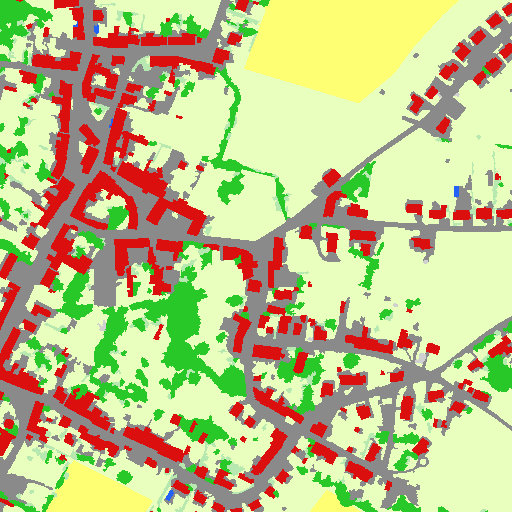

In [11]:
asimg(response)

De la même manière, nous pouvons également nous servir de ce service `WMS` pour extraire les orthophotos centrées sur notre `POINT` d'intérêt:

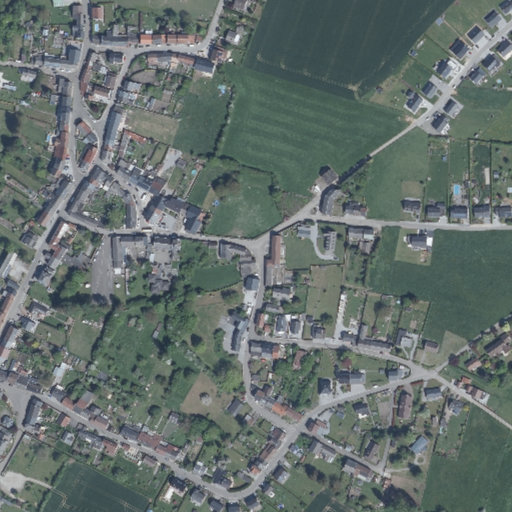

In [13]:
ortho_wms_url_template = "https://geoservices.wallonie.be/arcgis/services/IMAGERIE/ORTHO_{img_year}{infrared}/MapServer/WMSServer?FORMAT=image/{format}&VERSION=1.1.1&SERVICE=WMS&REQUEST=GetMap&LAYERS=0&STYLES=&SRS={proj}&WIDTH={width}&HEIGHT={height}&BBOX={bbox}"

response = wms_download(
    ortho_wms_url_template,
    bbox,           # Voir bbox définie précédemment
    img_year=2018,  # Vous pouvez changer l'année des orthophotos
    infrared="",
    format="jpeg",
    proj=proj,
    width=WIDTH,
    height=HEIGHT,
)

asimg(response)

Le problème de ce service, c'est qu'il ne permet pas d'obtenir les données brutes. Par exemple, pour la carte d'occupation, nous n'obtenons pas directement les labels/classes mais plutot les valeurs RGB de la couleur associée à la classe telle que définie dans la symbologie. Pour les orthophotos, nous obtenons les données en 8bits au lieu de 16bits. De plus, les requêtes pour le `format` `tiff` ne retournent pas la matrice `Affine` qui est une information nécéssaire pour le géoréférencement de la donnée (pour en apprendre plus sur cette matrice `Affine`: https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html#affine). Cela est illustré ci-dessous par l'avertissement `NotGeoreferencedWarning` obtenu lorsqu'on utilise le `format` `tiff`:

In [12]:
response = wms_download(
    ocs_wms_url_template,
    bbox,
    format="tiff",
    proj=proj,
    width=WIDTH,
    height=HEIGHT,
)
with rio.open(response) as r:
    print(r.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


/opt/anaconda3/envs/walous/lib/python3.7/site-packages/rasterio/io.py:130: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  return DatasetReader(mempath, driver=driver, sharing=sharing, **kwargs)


------

### Charger, lire, et visualiser la carte d'utilisation du sol, au format _raster_, disponible localement

> _Objectifs_: Ouvrir la carte d'occupation du sol via `rasterio`, interpréter les métadonnées, selectionner une zone d'intérêt et visualiser les données

Dans le cas où la carte d'occupation du sol (ou toutes autres données _raster_) est déjà disponible localement, on peut directement utiliser la librairie `rasterio` pour charger et lire la donnée.

Dans cette section, nous allons voir comment vous pouvez ouvrir un fichier `tif` et en interpréter les métadonnées. Ensuite, puisque la donnée peut être trop volumineuse pour en lire le contenu entier, nous verrons comment en lire une sous-section.
Pour ce faire nous allons suivre les étapes suivantes:
- définir le chemin d'accès vers le fichier contenant la carte d'occupation du sol
- ouvrir ce fichier et en lire les métadonnées
- définir une zone d'intérêt et lire les données de la carte d'occupation du sol pour cette zone
- adapter les métadonnées
- visualiser les données


La première étape va être de renseigner le chemin d'accès vers le fichier `tif` de la carte d'occupation du sol:

_Si vous travaillez sur `Binder`, veuillez d'abord télécharger la donnée et l'uploader sur l'environnement de travail de `Binder`._

In [19]:
OCS_RASTER_FP = "data/WAL_OCS_IA__2019.tif"  # A adapter celui l'emplacement du fichier

Pour ouvrir le fichier, la librairie `rasterio` peut être utilisée. A ce stade, seules les métadonnées du fichier sont lues. Les données ne seront, quant à elles, lues que si la demande en est faite. Pour le moment, contentons-nous d'afficher les métadonnées du raster ainsi ouvert:

In [20]:
with rio.open(OCS_RASTER_FP) as r:
    print(r.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 260000, 'height': 150000, 'count': 1, 'crs': CRS.from_epsg(3812), 'transform': Affine(1.0, 0.0, 540000.0,
       0.0, -1.0, 670000.0)}


Voici ce qu'il peut être retiré comme information de ces métadonnées:
- driver `GTiff` -> on a donc bien à faire à un `tif` géoréférencé
- dtype `uint8` -> type de la donnée: entier 8bits non signé (i.e. pas de valeurs négatives)
- nodata `None` -> valeur assignée au pixel sans donnée
- width/height -> largeur et hauteur en pixel
- count `1` -> nombre de bandes
- crs `3812` -> système de référence (Lambert belge 2008: EPSG:3812)
- transform `Affine` -> matrice `Affine` décrivant la transformation du raster

Ces métadonnées décrivent le raster dans son ensemble. Si, comme dans l'étape du dessous, nous extrayons une région de ce raster, ces métadonnées resteront identiques et ne seront pas adaptées automatiquement à la région extraite. Ces métadonnées doivent donc être attentivement controlées et adaptées lorsqu'on manipule le raster pour que celles-ci reflètent toujours bien la donnée avec laquelle on travaille. Sans adaptation de ces métadonnées, il sera impossible de géoréférencer la donnée par la suite.<br>
Voyons comment lire la zone d'intérêt définie ultérieurement grâce à notre `BBOX`. Tout d'abord, il faudra définir une `WINDOW`, c'est-à-dire une fenêtre décrivant les tranches de pixels à lire. Pour déterminer cette `WIDNOW`, on peut utiliser la fonction `geometry_window` de `rasterio` qui dérive cette fenêtre sur base d'une géométrie telle qu'une `BBOX`. Ensuite, la fonction `read` utilisée en conjonction avec la nouvelle fenêtre définie, nous permettra de lire uniquement les données du raster qui sont couvertes par la zone d'intérêt:

In [21]:
with rio.open(OCS_RASTER_FP) as r:
    window = geometry_window(r, [bbox])
    data = r.read(window=window)
    meta = r.meta
    print("Les metadonnées sont:", meta)
    print("Les dimensions spatiales sont:", data.shape)

Les metadonnées sont: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 260000, 'height': 150000, 'count': 1, 'crs': CRS.from_epsg(3812), 'transform': Affine(1.0, 0.0, 540000.0,
       0.0, -1.0, 670000.0)}
Les dimensions spatiales sont: (1, 512, 512)


On remarque que les métadonnées n'ont pas été adaptées à la lecture de la région. En effet les valeurs de `width` et `height` sont toujours de 260000 et 150000 alors que celles des données lues sont de 512 et 512. Il faut donc adapter les métadonnées pour garder celles-ci alignées avec les données sur lesquelles on travaille:

In [22]:
meta["height"], meta["width"] = data.shape[1:]
meta["transform"] = windows.transform(window, meta["transform"])
print("Les metadonnées adaptées: ", meta)

Les metadonnées adaptées:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(3812), 'transform': Affine(1.0, 0.0, 662459.0,
       0.0, -1.0, 611395.0)}


Afin de visualiser les données lues et contenues dans la variable `data`, il faut:
- définir la symbologie de la carte d'occupation du sol
- convertir les classes/labels en format RGB


En effet, les données dans le raster font références aux classes directement:

In [23]:
data

array([[[9, 9, 9, ..., 7, 7, 7],
        [9, 9, 9, ..., 7, 7, 7],
        [9, 9, 9, ..., 1, 7, 7],
        ...,
        [1, 1, 1, ..., 7, 7, 7],
        [1, 1, 1, ..., 7, 7, 7],
        [1, 1, 1, ..., 7, 7, 7]]], dtype=uint8)

Définissons donc la symbologie de la carte d'occupation:

In [24]:
OCS_CMAP = {
    1: (138, 138, 138),
    2: (220, 15, 15),
    3: (78, 78, 78),
    4: (208, 208, 208),
    5: (36, 97, 247),
    6: (255, 255, 115),
    7: (233, 255, 190),
    8: (0, 50, 0),
    9: (40, 200, 40),
    11: (138, 138, 138),
    15: (138, 138, 138),
    18: (138, 138, 138),
    19: (138, 138, 138),
    28: (220, 15, 15),
    29: (220, 15, 15),
    31: (78, 78, 78),
    38: (78, 78, 78),
    39: (78, 78, 78),
    51: (36, 97, 247),
    55: (36, 97, 247),
    58: (36, 97, 247),
    59: (36, 97, 247),
    62: (255, 85, 0),
    71: (233, 255, 190),
    73: (233, 255, 190),
    75: (233, 255, 190),
    80: (0, 120, 0),
    81: (0, 50, 0),
    83: (0, 50, 0),
    85: (0, 50, 0),
    90: (183, 232, 176),
    91: (40, 200, 40),
    93: (40, 200, 40),
    95: (40, 200, 40),
    255: (255, 255, 255),  # Nodata
}

Ensuite, implémentons les fonctions pour convertir les données d'origine (labels) en format RGB:

In [28]:
def to_mapping_array(mapping_dict: Dict[int, Union[int, List[int]]]) -> np.ndarray:
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    if v.ndim > 1:
        map_array_shape = (k.max() + 1, v.shape[1])
    else:
        map_array_shape = k.max() + 1
    mapping_array = np.zeros(map_array_shape, dtype="uint8")
    mapping_array[k] = v
    return mapping_array

In [29]:
def raster2img(data: np.ndarray, cmap: Dict[int, Tuple[int, int, int]] = OCS_CMAP):
    ocs_cmap_encoding = to_mapping_array(cmap)
    return Image.fromarray(ocs_cmap_encoding[data.squeeze()])

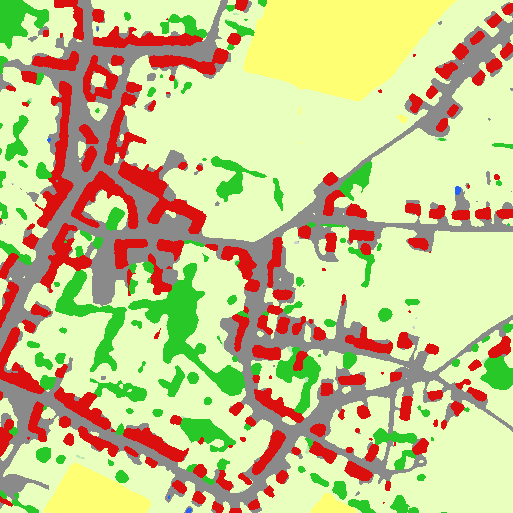

In [30]:
raster2img(data)

--------

### Rogner la carte d'occupation du sol sur base d'une zone d'intérêt

> _Objectifs_: Rogner la carte d'occupation du sol suivant une zone d'intérêt définie manuellement ou une _maille_/_tuile_

Dans de nombreux cas, on souhaitera rogner la donnée pour restreindre notre étude de cas à une zone prédéfinie.

Il faut donc définir notre zone d'intérêt via un format _vectoriel_, comme `GeoJSON` ou `ShapeFile`.

Un fichier de ce type est fourni et voyons dans un premier temps comment rogner le raster via la fonction `mask` de la librairie `rasterio` pour cette zone d'intérêt.

In [31]:
AOI_FP = "data/aoi_rognage.geojson"

Ce fichier peut être lu avec la librairie `geopandas`, comme ceci:

In [33]:
aoi = gpd.read_file(AOI_FP)
print(f"CRS de l'AOI: {aoi.crs}")

CRS de l'AOI: epsg:31370


Nous pouvons maintenant utiliser la fonction `mask` pour masquer/rogner le raster suivant la zone d'intérêt et visualiser le résultat:

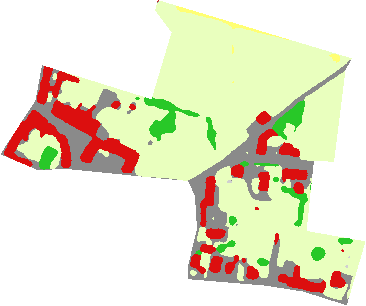

In [34]:
with rio.open(OCS_RASTER_FP) as r:
    data, affine = mask(
        r,
        aoi.to_crs(r.crs).geometry,
        all_touched=False,
        invert=False,
        crop=True,
        pad=False,
    )

raster2img(data)

Alternativement, les _tuiles_ et _mailles_ des fichiers de tuilage et de maillage peuvent également être utilisées à ces mêmes fins.

Tout d'abord, le fichier de maillage/tuilage est lu et chargé dans un `GeoDataFrame` via la librairie `geopandas`:

In [35]:
MAILLAGE_TUILAGE_FP = "data/ORTHOS_2018_MAILLES_TUILES_SHAPE_31370.zip!SPW_2018_{set}.shp"
maillage_tuilage_gdf = gpd.read_file(MAILLAGE_TUILAGE_FP.format(set="TUILAGE"))
maillage_tuilage_gdf

,OBJECTID,IMGLV3NAME,ACQ_TIME,ACQ_TIMEST,BANDS,RADIO_RES,SUN_ELEVAT,SUN_AZIMUT,AVG_HEIGHT,AER_HEIGHT,...,IMG_MOSDES,CKP_SOURCE,CKP_ACC_XY,CKP_ACC_Z,CKP_NUMBER,CKP_RMSE_X,CKP_RMSE_Y,CKP_RMSEXY,IMGORTNAME,geometry
0,6221.0,LV3_2018__1_029C_01910,20180626111738,11:17:38,4,64,62.52,169.6,607.61,4222.090,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680136;ORTHO_2018__00680137,"POLYGON ((274014.770 137991.251, 274003.280 13..."
1,6222.0,LV3_2018__1_029C_01909,20180626111725,11:17:25,4,64,62.52,169.5,573.29,4222.090,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680136;ORTHO_2018__00680137,"POLYGON ((275296.060 137953.431, 275296.060 13..."
2,6223.0,LV3_2018__1_029C_01908,20180626111712,11:17:12,4,64,62.51,169.4,593.80,4226.966,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680137;ORTHO_2018__00680138,"POLYGON ((276272.500 137942.351, 276291.240 13..."
3,6224.0,LV3_2018__1_029C_01907,20180626111659,11:16:59,4,64,62.51,169.3,633.05,4230.929,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00680138,"POLYGON ((277411.140 137974.591, 277401.490 13..."
4,6230.0,LV3_2018__7_045A_00855,20180505123003,12:30:03,4,64,54.07,202.9,227.69,4458.005,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660113;ORTHO_2018__00670113,"POLYGON ((226327.250 135944.131, 226385.350 13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6315,6070.0,LV3_2018__8_059A_01118,20180505162300,16:23:00,4,64,23.95,266.9,206.08,4442.467,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660114;ORTHO_2018__00660115;ORTH...,"POLYGON ((229255.880 135475.131, 229295.630 13..."
6316,6071.0,LV3_2018__8_059A_01117,20180505162247,16:22:47,4,64,23.98,266.9,235.44,4439.336,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660114;ORTHO_2018__00660115;ORTH...,"POLYGON ((230050.280 135522.501, 230057.610 13..."
6317,6072.0,LV3_2018__8_059A_01116,20180505162234,16:22:34,4,64,24.00,266.8,248.01,4437.115,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660115;ORTHO_2018__00660116;ORTH...,"POLYGON ((231385.130 135388.881, 231451.880 13..."
6318,6104.0,LV3_2018__8_059A_01084,20180505161609,16:16:09,4,64,24.71,266.0,546.20,4439.023,...,Global tiling,PICC,0.08,0.1,12,0.121,0.128,0.176,ORTHO_2018__00660132;ORTHO_2018__00660133;ORTH...,"POLYGON ((265289.470 135475.971, 265307.630 13..."


Ensuite une _maille_/_tuile_ est sélectionnée, par exemple sur base de son nom. Finalement cette _maille_/_tuile_ est utilisée pour lire et rogner une zone précise de la carte d'occupation du sol:

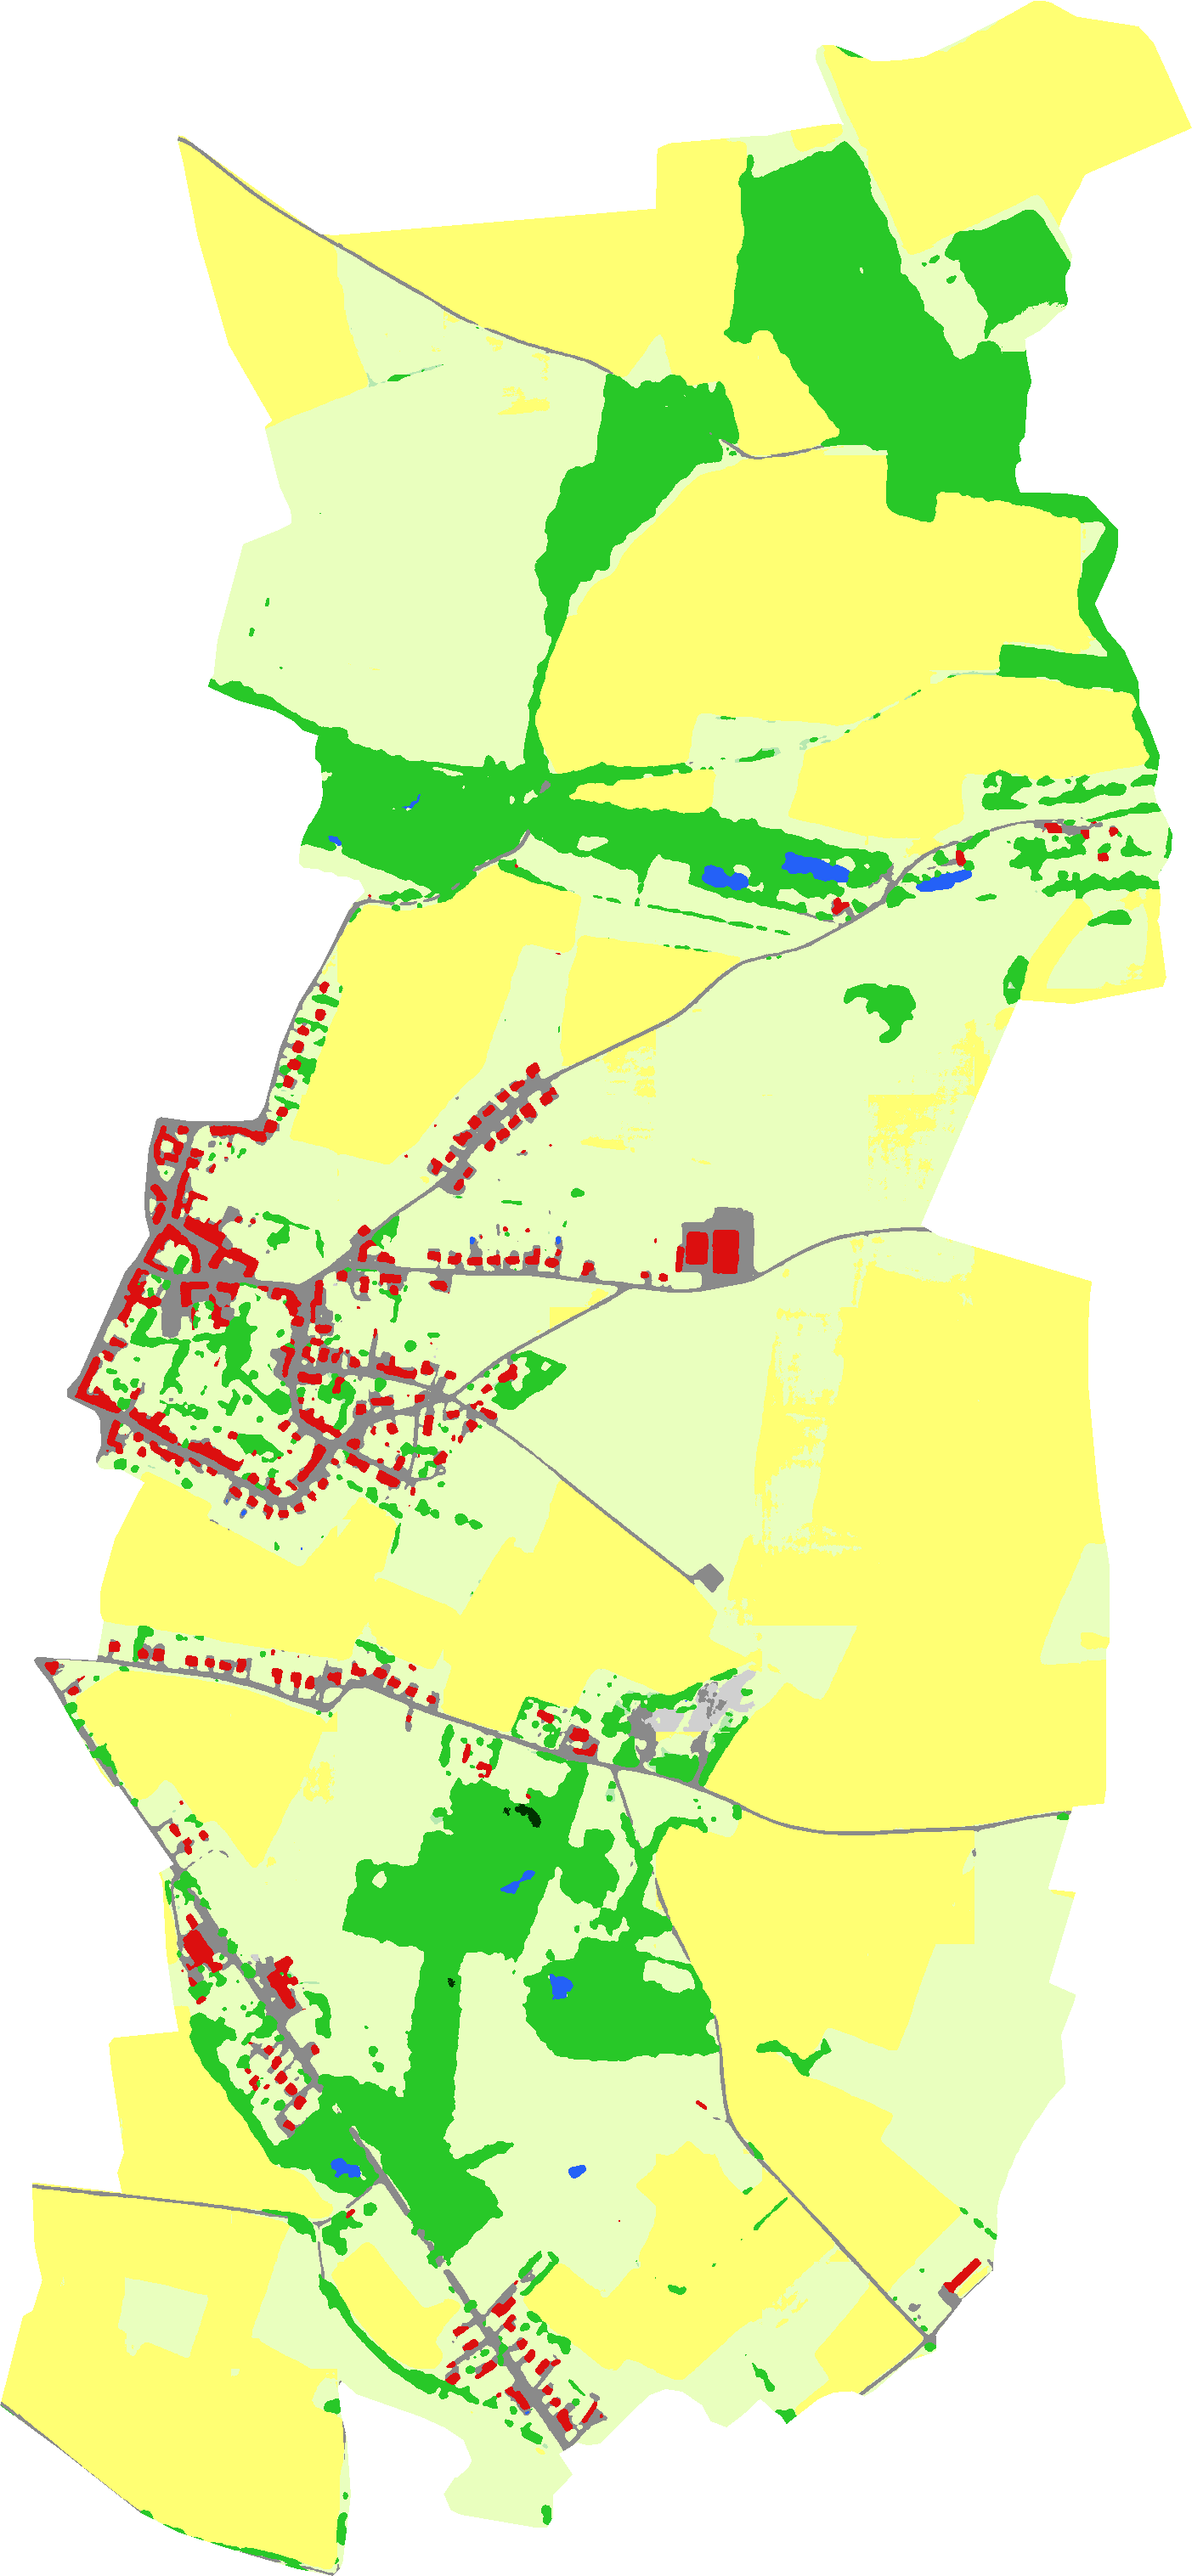

In [36]:
IMAGE_NAME = "ORTHO_2018__00550081"
IMGLV3NAME = "LV3_2018__7_053A_00276"

maille_tuile = maillage_tuilage_gdf[maillage_tuilage_gdf["IMGLV3NAME"]==IMGLV3NAME]

with rio.open(OCS_RASTER_FP) as r:
    data, affine = mask(
        r,
        maille_tuile.to_crs(r.crs).geometry,
        crop=True,
    )

raster2img(data)

---------

### Vectoriser une zone d'intérêt de la carte d'occupation du sol

> _Objectifs_: Vectoriser une région de la carte d'occupation du sol

Pour de petites régions, la vectorisation du raster peut se faire simplement via la fonction `features.shapes` de `rasterio`.

Illustrons cette fonctionnalité en vectorisant la _maille_/_tuile_ sélectionnée précédemment. Chaque polygone est sauvé dans une `Feature` et tous les polygones sont regroupés dans un `GeoDataFrame`.

In [27]:
with rio.open(OCS_RASTER_FP) as r:
    data, affine = mask(
        r,
        maille_tuile.to_crs(r.crs).geometry,
        crop=True,
    )
    meta = r.meta

features = []
for polygon, value in shapes(data, transform=affine, connectivity=4):
    features.append(Feature(geometry=polygon, properties={"label": int(value)}))
gdf = gpd.GeoDataFrame.from_features(features, crs=meta["crs"])
gdf.to_file("data/eg_vectorisation.shp")  # Pour sauver les résultats
gdf

,geometry,label
0,"POLYGON ((663532.746 612640.347, 663532.746 61...",7
1,"POLYGON ((663344.747 612611.347, 663344.747 61...",9
2,"POLYGON ((663501.746 612624.347, 663501.746 61...",7
3,"POLYGON ((663345.747 612610.347, 663345.747 61...",9
4,"POLYGON ((662570.754 612506.348, 662570.754 61...",6
...,...,...
2559,"POLYGON ((662721.753 609640.373, 662721.753 60...",7
2560,"POLYGON ((662754.752 609636.373, 662754.752 60...",1
2561,"POLYGON ((662740.753 609635.373, 662740.753 60...",7
2562,"POLYGON ((662745.752 609634.373, 662745.752 60...",7
